<a href="https://colab.research.google.com/github/ivanpalenciab/Sentiment-analysis/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
%pip install pyarrow
%pip install transformers

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from textwrap import wrap
from joblib import dump, load
import seaborn as sns

In [40]:
RANDOM_SEED = 30
MAX_LEN = 200
FILE_ROUTE = "/content/drive/MyDrive/Sentiment analysis/Datos/"
BATCH_SIZE = 16
NCLASSES = 3

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [41]:
#First dataset Import
df= pd.read_parquet(f"{FILE_ROUTE}spanish%2Fmultilingual-sentiments-train.parquet")
df.drop("source",axis=1,inplace=True)

In [42]:
#Second dataframe imported
df_2 = pd.read_parquet(f"{FILE_ROUTE}spanish%2Fmultilingual-sentiments-test.parquet")
df_2.drop("source",axis=1,inplace=True)
#test_df = df_2

In [43]:
#data augmented import
#data_augmented = pd.read_csv(f"{FILE_ROUTE}data_augmented.csv")

In [44]:
#third dataframe imported
df_3 = pd.read_parquet(f"{FILE_ROUTE}spanish%2Fmultilingual-sentiments-validation.parquet")
df_3.drop("source",axis=1,inplace=True)

In [73]:
df_sampled = df_2.groupby('label').sample(n=80, random_state=RANDOM_SEED)
#df_train = pd.concat([df, df_sampled])
test_df = df_2.drop(df_sampled.index)
df_train = pd.concat([df, df_3,df_sampled])

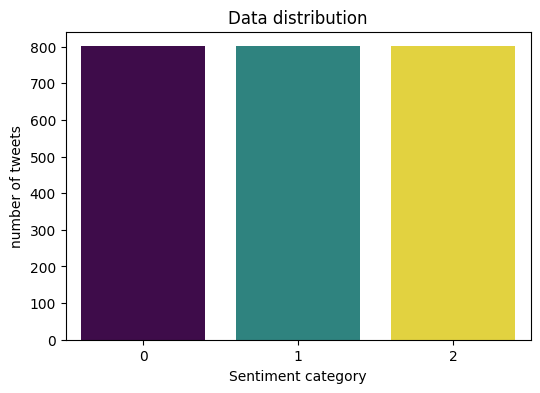

In [74]:
plt.figure(figsize=(6,4))
sns.countplot(x=df_train["label"], hue=df_train["label"], palette="viridis", legend=False)

# Etiquetas y título
plt.xlabel("Sentiment category")
plt.ylabel("number of tweets")
plt.title("Data distribution")

# Mostrar gráfico
plt.show()

In [75]:
print(f"porcentaje de datos de testeo {round(test_df.shape[0]/df_train.shape[0]*100)} %")

porcentaje de datos de testeo 26 %


In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2403 entries, 0 to 804
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2403 non-null   object
 1   label   2403 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 56.3+ KB


In [77]:
df_train["label"].unique()


array([2, 1, 0])

In [78]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630 entries, 2 to 869
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    630 non-null    object
 1   label   630 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.8+ KB


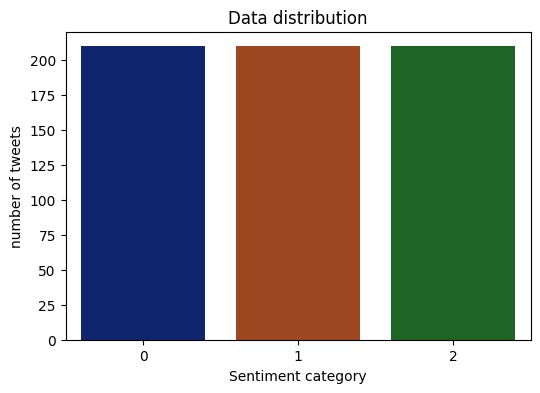

In [79]:
plt.figure(figsize=(6,4))
sns.countplot(x=test_df["label"], hue=test_df["label"], palette="dark", legend=False)

# Etiquetas y título
plt.xlabel("Sentiment category")
plt.ylabel("number of tweets")
plt.title("Data distribution")

# Mostrar gráfico
plt.show()

In [80]:
#tokenitation
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [81]:
# tokenitation example
sample_txt = '¡realmente me gusta la hamburguesa!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  ¡realmente me gusta la hamburguesa!
Tokens:  ['¡', 'realmente', 'me', 'gusta', 'la', 'hamburguesa', '!']
Tokens numéricos:  [1139, 3189, 1129, 2816, 1030, 27035, 1127]


In [82]:
# Codificactio to introduce in BERT
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 11,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding='max_length',
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [83]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [84]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', '¡', 'realmente', 'me', 'gusta', 'la', 'hamburguesa', '!', '[SEP]', '[PAD]', '[PAD]']
tensor([    4,  1139,  3189,  1129,  2816,  1030, 27035,  1127,     5,     1,
            1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])


In [85]:
#dataset creation
class my_dataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    label = self.label[item]
    encoding = tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding="max_length",
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [86]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = my_dataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 2)

In [87]:
train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [88]:
#Model
class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids = input_ids,attention_mask = attention_mask)
    cls_output = outputs.pooler_output
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [89]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
#training
EPOCHS = 5
optimizer = optim.AdamW(model.parameters(), lr=1e-5 , betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [100]:
# Training iterataion
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [106]:
# Entrenamiento!!!

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(test_df)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------
Entrenamiento: Loss: 0.04627011338256944, accuracy: 0.9925093632958802
Validación: Loss: 3.1081520944833754, accuracy: 0.6619047619047619

Epoch 2 de 5
------------------
Entrenamiento: Loss: 0.04300710105936433, accuracy: 0.990012484394507
Validación: Loss: 2.6814093639142813, accuracy: 0.7047619047619048

Epoch 3 de 5
------------------
Entrenamiento: Loss: 0.03384395153527944, accuracy: 0.9933416562630046
Validación: Loss: 2.761714793125793, accuracy: 0.6873015873015873

Epoch 4 de 5
------------------
Entrenamiento: Loss: 0.01938628216555195, accuracy: 0.9962546816479402
Validación: Loss: 2.5858025629288024, accuracy: 0.7126984126984127

Epoch 5 de 5
------------------
Entrenamiento: Loss: 0.00567904629817638, accuracy: 0.9991677070328756
Validación: Loss: 2.5648072135829354, accuracy: 0.7031746031746031



In [107]:
def classifySentiment(review_text):
  encoding_review = tokenizer.encode_plus(
      review_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
       padding="max_length",
      return_attention_mask = True,
      return_tensors = 'pt'
      )

  input_ids = encoding_review['input_ids'].to(device)
  attention_mask = encoding_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  prediction = torch.argmax(output, dim=1)   # Obtener la clase con mayor probabilidad

  # Mapeo de clases según la nueva clasificación de tres categorías
  sentiment_labels = {0: "Positivo", 1: "Neutral", 2: "Negativo"}

  print("\n".join(wrap(review_text)))
  print(f'Sentimiento predicho: {sentiment_labels[prediction.item()]}')

In [108]:
#text = "esta fue una experiancia bastante desagradables, esperaba algo mejor."
text ="no estubo mal"

classifySentiment(text)

no estubo mal
Sentimiento predicho: Positivo


In [110]:
#saving model
ROUTE = "/content/drive/MyDrive/Sentiment analysis/Models/"
torch.save(model.state_dict(), "BERTo_model_parameters.pth")
torch.save(model, f"{ROUTE}/BERTo_model.pth")
#to follow tunning
torch.save({"modelo_state_dict":model.state_dict,
            "optimizer_state_dict":optimizer.state_dict},"checkpoint.pth")

In [111]:
#test_df_no_neu = test_df[test_df["label"]!=1]
#test_df_no_neu.head()

In [113]:
ROUTE = "/content/drive/MyDrive/Sentiment analysis/Models/"

try:
  charged_model = load(f"{ROUTE}/BERTo_model.joblib")
  print("charged in gpu")
except:
  charged_model = torch.load(f"{ROUTE}/BERTo_model.joblib", map_location=torch.device('cpu'))
  print("charged in cpu")

#model = BERTSentimentClassifier(NCLASSES)
#model = model.to(device)

charged in gpu
